# K-fold CrossValidation COCO Dataset Generator

### Hi kagglers, This is `K-fold CrossValidation COCO Dataset Generator` notebook.
* [Sartorius Segmentation - Detectron2 [training]](https://www.kaggle.com/ammarnassanalhajali/sartorius-segmentation-detectron2-training) 
* [Sartorius Segmentation - Detectron2 [Inference]](https://www.kaggle.com/ammarnassanalhajali/sartorius-segmentation-detectron2-inference) 

### Please if this kernel is useful, <font color='red'>please upvote !!</font>

## Other notebooks in this competition 
- [Sartorius Segmentation - Keras U-Net[Training]](https://www.kaggle.com/ammarnassanalhajali/sartorius-segmentation-keras-u-net-training)
- [Sartorius Segmentation - Keras U-Net[Inference]](https://www.kaggle.com/ammarnassanalhajali/sartorius-segmentation-keras-u-net-inference/edit)

# importing libraries


In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from tqdm.notebook import tqdm
from datetime import datetime
import json,itertools
from typing import Optional
from sklearn.model_selection import StratifiedKFold


# Loading Dataset

In [2]:
train_df = pd.read_csv('../input/sartorius-cell-instance-segmentation/train.csv')
print(train_df.shape)
train_df.head(4)

(73585, 9)


,id,annotation,width,height,cell_type,plate_time,sample_date,sample_id,elapsed_timedelta
0,0030fd0e6378,118145 6 118849 7 119553 8 120257 8 120961 9 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
1,0030fd0e6378,189036 1 189739 3 190441 6 191144 7 191848 8 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
2,0030fd0e6378,173567 3 174270 5 174974 5 175678 6 176382 7 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
3,0030fd0e6378,196723 4 197427 6 198130 7 198834 8 199538 8 2...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00


In [3]:

def rle_decode(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)  # Needed to align to RLE direction

# From https://newbedev.com/encode-numpy-array-using-uncompressed-rle-for-coco-dataset
def binary_mask_to_rle(binary_mask):
    rle = {'counts': [], 'size': list(binary_mask.shape)}
    counts = rle.get('counts')
    for i, (value, elements) in enumerate(itertools.groupby(binary_mask.ravel(order='F'))):
        if i == 0 and value == 1:
            counts.append(0)
        counts.append(len(list(elements)))
    return rle

In [4]:
def coco_structure(train_df):
    cat_ids = {name:id+1 for id, name in enumerate(train_df.cell_type.unique())}    
    cats =[{'name':name, 'id':id} for name,id in cat_ids.items()]
    images = [{'id':id, 'width':row.width, 'height':row.height, 'file_name':f'train/{id}.png'} for id,row in train_df.groupby('id').agg('first').iterrows()]
    annotations=[]
    for idx, row in tqdm(train_df.iterrows()):
        mk = rle_decode(row.annotation, (row.height, row.width))
        ys, xs = np.where(mk)
        x1, x2 = min(xs), max(xs)
        y1, y2 = min(ys), max(ys)
        enc =binary_mask_to_rle(mk)
        seg = {
            'segmentation':enc, 
            'bbox': [int(x1), int(y1), int(x2-x1+1), int(y2-y1+1)],
            'area': int(np.sum(mk)),
            'image_id':row.id, 
            'category_id':cat_ids[row.cell_type], 
            'iscrowd':0, 
            'id':idx
        }
        annotations.append(seg)
    return {'categories':cats, 'images':images,'annotations':annotations}

In [5]:
train_df = pd.read_csv('../input/sartorius-cell-instance-segmentation/train.csv')
train_meta = train_df.groupby('id').first().reset_index()

In [6]:
n_splits=5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
for fold, (_, val_idx) in enumerate(skf.split(X=train_meta, y=train_meta['cell_type']), 1):
    train_meta.loc[val_idx, 'fold'] = fold
    
train_meta['fold'] = train_meta['fold'].astype(np.uint8)
train_meta.groupby('fold').size()

fold
1    122
2    121
3    121
4    121
5    121
dtype: int64

In [7]:
fold_selected=1 # 1..5

train_ids = train_meta[train_meta["fold"]!=fold_selected].id
test_ids = train_meta[train_meta["fold"]==fold_selected].id

df_train = train_df[train_df.id.isin(train_ids)]
df_valid = train_df[train_df.id.isin(test_ids)]

train_json = coco_structure(df_train)
valid_json = coco_structure(df_valid)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [8]:
df_valid.groupby('cell_type').size()

cell_type
astro      2249
cort       2000
shsy5y    10317
dtype: int64

In [9]:
df_train.groupby('cell_type').size()

cell_type
astro      8273
cort       8777
shsy5y    41969
dtype: int64

In [10]:
with open(f'coco_cell_train_fold{fold_selected}.json', 'w', encoding='utf-8') as f:
    json.dump(train_json, f, ensure_ascii=True, indent=4)

with open(f'coco_cell_valid_fold{fold_selected}.json', 'w', encoding='utf-8') as f:
    json.dump(valid_json, f, ensure_ascii=True, indent=4)

# Refrences
* https://www.kaggle.com/coldfir3/efficient-coco-dataset-generator?scriptVersionId=79100851
* https://www.kaggle.com/slawekbiel/positive-score-with-detectron-1-3-input-data
* https://www.kaggle.com/c/sartorius-cell-instance-segmentation/discussion/285546

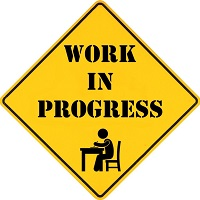